In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import numpy as np
import astropy.io.fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import scipy.stats as stats
from astropy.stats import sigma_clip
from colossus.halo import profile_nfw
import sherpa.astro.ui as ui
cosmo = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology
c=const.c.to("km/s").value
#%matplotlib notebook


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
col1_data = []
col2_data = []
col3_data = []
with open('newcluster.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        col1_data.append(float(row[0]))
        col2_data.append(float(row[1]))
        col3_data.append(float(row[2]))
        
RA=np.array(col1_data )
DEC=np.array(col2_data) 
Z= np.array(col3_data)


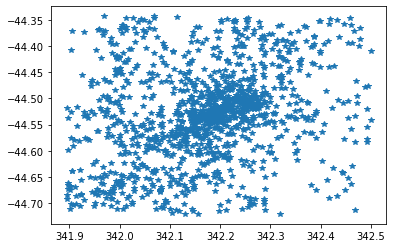

In [3]:
#first sorting
# Create a boolean mask for values within the desired range
mask = np.logical_and(Z >= 0.32, Z <= 0.36)  # the range of  redshift for the cluster

# Use the mask to get only the values within the desired range
z = Z[mask]
ra= RA[mask]
dec= DEC[mask]
ra_cl= np.mean(ra)
dec_cl= np.mean(dec)
z_cl= np.mean(z)
plt.plot(RA[mask], DEC[mask], '*')


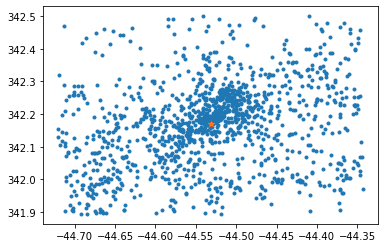

In [4]:
# projection of the cluster
plt.plot(dec,ra,'.')
plt.plot(dec_cl,ra_cl,'*',color='red')
#plt.plot(dec[mask_ma],ra[mask_ma],'o')
plt.plot(dec_cl,ra_cl,'*')
plt.show()


len(ra),len(dec),len(z)
c1 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree ,frame='icrs')
c2 = SkyCoord(ra=ra_cl*u.degree, dec=dec_cl*u.degree, frame='icrs')
sep = c1.separation(c2)
sep_radian=sep.radian 

# proj distance
r_proj_c=(sep_radian* cosmo.angular_diameter_distance(z_cl)/u.radian).value
exclude_value = 2.63

r_proj = r_proj_c[r_proj_c <= exclude_value]
mask_ma=np.where(r_proj)
los_v= c*(z[mask_ma]- z_cl)/1+z_cl

In [5]:
z_final=(z[mask_ma])
ra_final= ra[mask_ma]
dec_final= dec[mask_ma]

In [6]:
r_proj.max()

2.6294646404098514

In [7]:
# all member under r200
len(r_proj),len(ra[mask_ma]),len(z_final)

(873, 873, 873)

# cluster Caustic analysis

In [8]:
cluster_data=np.vstack((ra_final,dec_final,z_final)).T
len(cluster_data)

873

In [9]:
import causticpy
caustic= causticpy.Caustic()
caustic.run_caustic(cluster_data)


DATA SET SIZE 797
Pre_r200= 1.8589768183021642
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1506.3246062871294
Combined Vdisp= 1506.3246062871294
Calculating initial surface
complete


1

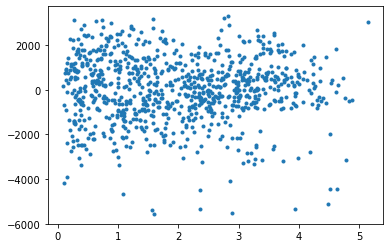

In [10]:
caustic.r.max(),r_proj.min()
plt.plot(caustic.r,caustic.v,'.',linestyle='none')

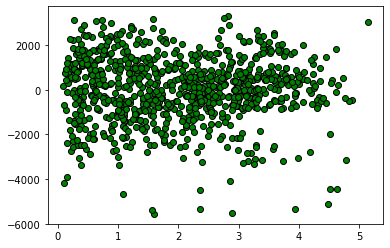

In [11]:
plt.plot(caustic.r,caustic.v,color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='green', markersize=12)
#plt.plot(r_proj,los_v_r,color='black', linestyle='none', linewidth = 2, marker='+', markerfacecolor='red', markersize=12)


In [12]:
caustic.run_caustic(cluster_data,clus_ra=caustic.clus_ra,clus_dec=caustic.clus_dec,clus_z=caustic.clus_z)

DATA SET SIZE 797
Pre_r200= 1.8589768183021642
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1506.3246062871294
Combined Vdisp= 1506.3246062871294
Calculating initial surface
complete
r200 estimate:  2.0271701524739987
M200 estimate:  2628817396146864.0


1

In [13]:
caustic.r200_est

array(2.07383261)

In [14]:
caustic.M200_est/ 1e15

2.814589192255969

In [15]:
caustic.angle
z_cl=caustic.clus_z
caustic.ang_d
caustic.lum_d
caustic.v
caustic.data_set.T # velocities powerlaw(x, a, b):
caustic.x_range
caustic.y_range
caustic.img_tot
caustic.caustic_profile
caustic.caustic_fit
caustic.gal_vdisp


1506.3246062871294

<function matplotlib.pyplot.show(*, block=None)>

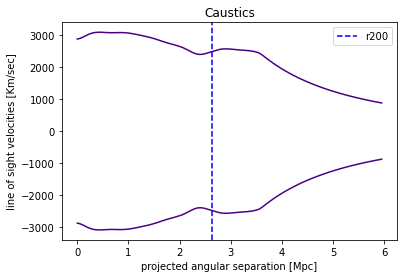

In [16]:
plt.title('Caustics')
caustic_profile=caustic.caustic_profile
caustic_radii=caustic.x_range
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')  # assumes caustic
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
plt.axvline(x = 2.63, linestyle='dashed',color = 'b', label = 'r200')
#plt.savefig(' Caustic lines.pdf',dpi=300)
plt.legend()
plt.show

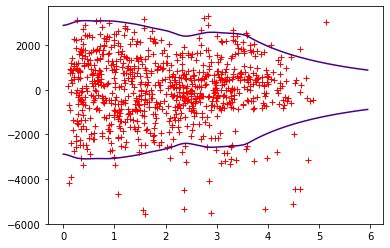

In [17]:
plt.plot(caustic.r,caustic.v,color='red', linestyle='none',marker='+')
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo') 

In [18]:
projected_radius=np.array(caustic.r)
#peculiar_velocity=np.array(los_v)
cluster_redshift=caustic.clus_z
cluster_RA=caustic.clus_ra
cluster_DEC=caustic.clus_dec

caustic_profile=caustic.caustic_profile

caustic_mask = np.array([x==1 for x in caustic.memflag])
cut_radius = np.transpose(caustic.data_set)[0]
cut_velocity = np.transpose(caustic.data_set)[1]
cut_RA = np.transpose(caustic.data_set)[2]
cut_DEC = np.transpose(caustic.data_set)[3]
cut_z = np.transpose(caustic.data_set)[4]

trimmed_radius = cut_radius[caustic_mask]
trimmed_velocity = cut_velocity[caustic_mask]

<function matplotlib.pyplot.show(*, block=None)>

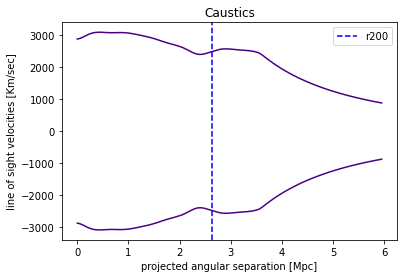

In [19]:
plt.title('Caustics')
caustic_profile=caustic.caustic_profile
caustic_radii=caustic.x_range
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')  # assumes caustic
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
plt.axvline(x = 2.63, linestyle='dashed',color = 'b', label = 'r200')
#plt.savefig(' Caustic lines.pdf',dpi=300)
plt.legend()
plt.show

<function matplotlib.pyplot.show(*, block=None)>

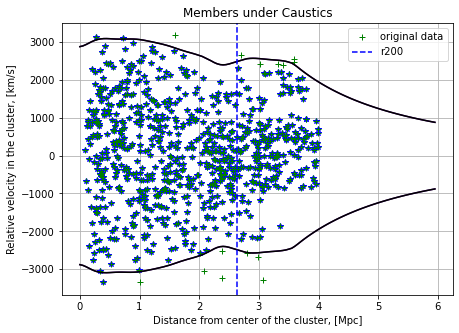

In [20]:
# plot the original and rejected data
fig, ax = plt.subplots(1, 1, figsize=(7,5))
plt.title('Members under Caustics')
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')
plt.plot(trimmed_radius,trimmed_velocity,'*',color='blue',)
plt.plot(cut_radius,cut_velocity, '+', color='g', label="original data")
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
ax.plot(caustic.x_range, caustic.caustic_profile, c='black')
ax.plot(caustic.x_range, -caustic.caustic_profile, c='black')
ax.set_xlabel('Distance from center of the cluster, [Mpc]')
ax.set_ylabel('Relative velocity in the cluster, [km/s]')
plt.axvline(x = 2.63, linestyle='dashed',color = 'b', label = 'r200')

#plt.savefig('members inside the caustics.png', dpi=300)
ax.grid(True)
plt.legend()
plt.show



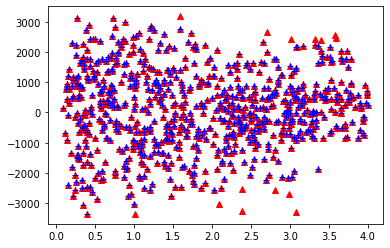

In [21]:
plt.plot(cut_radius, cut_velocity, '^', color='red')
plt.plot(trimmed_radius, trimmed_velocity, '+',color='blue')
#plt.plot(r_proj,los_v,'.')


In [22]:
h0=67.77
class MassCalc:
    """
    MassCalc(self,ri,A,vdisp,r200=None,conc1=None,beta=None,fbr=None):

        ri - rgrid values

        A - caustic profile values

        vdisp - galaxy velocity dispersion

        r200 = 2.0 - critical radius of cluster. Default is 2.0, but advised to take the output r200 and rerun
        the analysis with this better estimate.

        conc1 = None - concentration of cluster. If None given then calculated from relationship

        beta = 0.2 - Anisotrpy parameter. Default value is 0.2, but a profile can be given that has same xvalues as ri.

        fbr = None - An exact guess of Fbeta by whatever means. Usually not used.

        H0 = 100.0 - Hubble constant
    """
    
    def __init__(self,ri,A,vdisp,clus_z,r200=None,conc1=None,beta=0.25,fbr=None,H0=h0):
        "Calculate the mass profile"
        G = 6.67E-11
        solmass = 1.98892e30
        self.crit = 2.7745946e11*(H0/100.0)**2.0*(0.25*(1+clus_z)**3.0 + 0.75)
        r2 = ri[ri>=0]
        A2 = A[ri>=0]
        kmMpc = 3.08568025e19
        sumtot = np.zeros(A2.size)
        #print 'Using beta = %.2f'%(beta)
        if conc1 == None:
            #self.conc = 4.0*(vdisp/700.0)**(-0.306)
            self.conc = 5.0 + np.random.normal(0,2.0)
            if self.conc <= 0: self.conc = 5.0
        else:
            self.conc = conc1
        beta = 0.5*(ri/(ri+r200/self.conc))
        self.g_b = (3-2.0*beta)/(1-beta)
        if fbr is None:
            self.f_beta = 0.5*((r2/r200*self.conc)**2)/((1+((r2/r200*self.conc)))**2*np.log(1+((r2/r200*self.conc))))*self.g_b
            self.f_beta[0] = 0
            for i in range(A2.size-1):
                i += 1    
                sumtot[i] = np.trapz(self.f_beta[1:i+1]*(A2[1:i+1]*1000)**2,(r2[1:i+1])*kmMpc*1000)
                #sum[i] = np.trapz((A2[:i+1]*1000)**2,(r2[:i+1])*kmMpc*1000)
            #sum = integrate.cumtrapz(self.f_beta*(A2[:f_beta.size]*1000)**2,r2[:f_beta.size]*kmMpc*1000,initial=0.0)
        else:
            if type(fbr) == float or type(fbr) == int or type(fbr) == np.float64:
                self.f_beta = np.zeros(A2.size)+fbr*1.0
            else:
                self.f_beta = fbr
            self.f_beta[0] = 0
            for i in range(A2.size-1):
                i += 1    
                sumtot[i] = np.trapz(self.f_beta[1:i+1]*(A2[1:i+1]*1000)**2,(r2[1:i+1])*kmMpc*1000)
                #sum[i] = np.trapz((A2[:i+1]*1000)**2,(r2[:i+1])*kmMpc*1000)
            #sum = integrate.cumtrapz(self.f_beta*(A2[:f_beta.size]*1000)**2,r2[:f_beta.size]*kmMpc*1000,initial=0.0)
        self.massprofile = sumtot/(G*solmass)
        
        #return the caustic r200
        self.avg_density = self.massprofile/(4.0/3.0*np.pi*(ri[:self.f_beta.size])**3.0)
        try:
            #self.r200_est = (ri[:self.f_beta.size])[np.where(self.avg_density >= 200*self.crit)[0]+1][-1]
            finterp = interp1d(self.avg_density[::-1],ri[:self.f_beta.size][::-1])
            self.r200_est = finterp(200*self.crit)
            self.r500_est = finterp(500*self.crit)
        except IndexError:
            self.r200_est = 0.0
            self.r500_est = 0.0
        #self.M200_est = self.massprofile[np.where(ri[:self.f_beta.size] <= self.r200_est)[0][-1]]
        finterp = interp1d(ri[:self.f_beta.size],self.massprofile)
        self.M200_est = finterp(self.r200_est)
        self.M500_est = finterp(self.r500_est)
        self.M200 = self.massprofile[np.where(ri[:self.f_beta.size] <= r200)[0][-1]]
        

In [23]:
caustic.r200,caustic.vdisp_gal

(1.8589768183021642, 1248.6709461819946)

In [24]:
m = MassCalc(ri =caustic.x_range,
    A = caustic.caustic_profile,
    vdisp = caustic.vdisp_gal,
    clus_z = caustic.clus_z,
    r200=2.63,
    conc1=5,
    beta=0.33,
    fbr=None,
    H0=67.77,)

In [25]:
m.crit,m.conc,m.f_beta

(173093582170.11356,
 5,
 array([0.        , 0.12635392, 0.22628652, 0.30661519, 0.37206378,
        0.42599801, 0.47087373, 0.50852015, 0.54032437, 0.56735501,
        0.59044688, 0.61026032, 0.62732355, 0.64206337, 0.65482781,
        0.66590301, 0.67552605, 0.68389471, 0.69117505, 0.69750733,
        0.70301064, 0.70778665, 0.71192255, 0.71549342, 0.71856421,
        0.72119131, 0.72342384, 0.72530475, 0.72687172, 0.72815788,
        0.72919247, 0.73000134, 0.73060741, 0.73103106, 0.73129044,
        0.73140176, 0.7313795 , 0.73123665, 0.73098488, 0.73063466,
        0.73019545, 0.72967577, 0.72908332, 0.72842506, 0.7277073 ,
        0.72693578, 0.72611568, 0.72525174, 0.72434825, 0.72340913,
        0.72243797, 0.72143801, 0.72041224, 0.71936338, 0.71829392,
        0.71720615, 0.71610214, 0.71498383, 0.71385295, 0.71271112,
        0.71155983, 0.71040042, 0.70923415, 0.70806216, 0.7068855 ,
        0.70570514, 0.70452197, 0.7033368 , 0.7021504 , 0.70096344,
        0.69977657, 0.6

In [26]:
m.M200_est

array(3.46232764e+15)

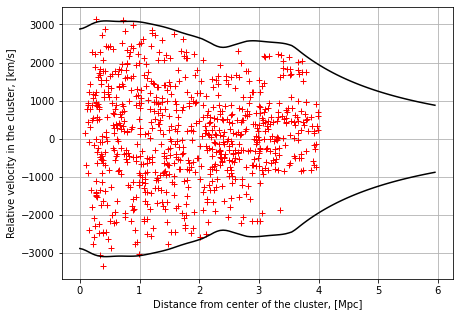

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(trimmed_radius,trimmed_velocity,'+',color='red',)

ax.plot(caustic.x_range, caustic.caustic_profile, c='black')
ax.plot(caustic.x_range, -caustic.caustic_profile, c='black')
ax.set_xlabel('Distance from center of the cluster, [Mpc]')
ax.set_ylabel('Relative velocity in the cluster, [km/s]')
ax.grid(True)

In [28]:
len(m.massprofile)

120

In [29]:
r_proj.max()

2.6294646404098514

In [30]:
r_proj_c.max()

5.099419815471792

In [31]:
len(r_proj_c)

1273

In [32]:
rr=np.linspace(0,r_proj_c.max(),len(m.massprofile))


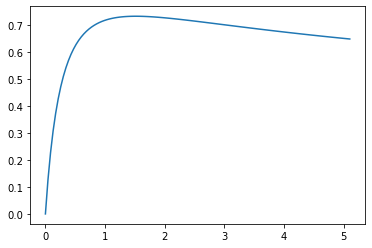

In [33]:
# filling factor
plt.plot(rr,m.f_beta)

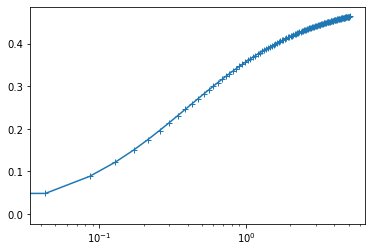

In [34]:
plt.plot(rr,caustic.beta,'+',linestyle='-')
plt.xscale('log')


In [35]:
dis=np.array([  -0.014218009478673244,0.3270142180094786,0.6492890995260663,0.981042654028436,1.3412322274881516,
1.7014218009478677,1.95260663507109,2.327014218009479,2.56872037914692,2.62])

mass_V= np.array([-42735042735042,273504273504274,897435897435897,1495726495726495.5,2136752136752136,2564102564102563.5,
3094017094017093.5,3384615384615384,3572649572649572,3672649572649572])

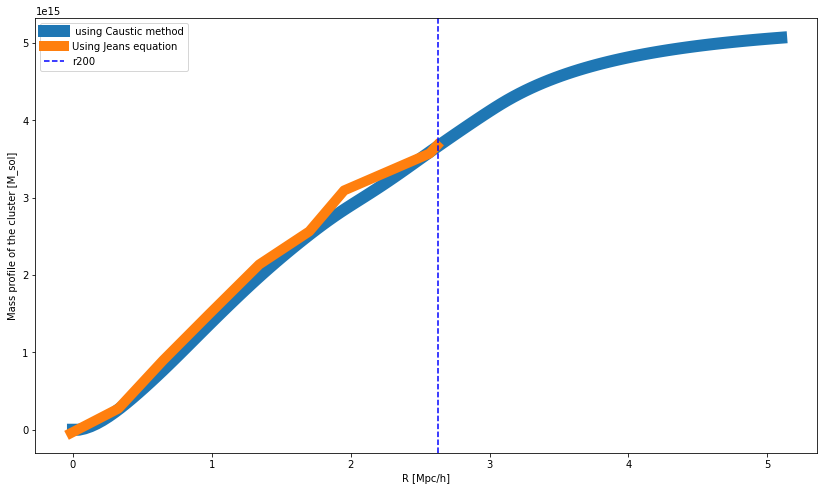

In [36]:
plt.figure(figsize=(14,8))
plt.plot(rr,m.massprofile,'*',linestyle='-',linewidth = '12',label=' using Caustic method')
plt.plot(dis,mass_V,linewidth = '10',label='Using Jeans equation ')
plt.axvline(x = 2.63, linestyle='dashed',color = 'b', label = 'r200')

plt.xlabel('R [Mpc/h]')
plt.ylabel('Mass profile of the cluster [M_sol]')
#plt.yscale('log')
#plt.loglog()
plt.legend()
plt.show()

# number density 

In [37]:
# number density profile
def poiss_err(n, alpha=0.32):
    sigma_lo = sp.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = sp.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

# density profile
def num_den(r_proj,nbins):
    nbins=9 #number of bins
    n_data,R_bins=np.histogram(r_proj, nbins, range=(r_proj.min(), r_proj.max()))
# ignore bin with zero count
    select = n_data > 0
    n_data = n_data[select]
    R_bins_low = R_bins[:-1][select]
    R_bins_high = R_bins[1:][select]

# compute poisson error  errors in n_data
    n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
    R_bins_ce = 0.5 * (R_bins_low + R_bins_high)

#  projected number density profile
    delta_R2 = (R_bins_high**2 - R_bins_low**2)
    Sig_data = n_data / (np.pi * delta_R2)
    Sig_data_low = n_data_low / (np.pi * delta_R2)
    Sig_data_high = n_data_high / (np.pi * delta_R2),

# error
    sig_low = Sig_data - Sig_data_low
    sig_high = Sig_data_high - Sig_data
    return R_bins_ce, Sig_data,sig_low,sig_high


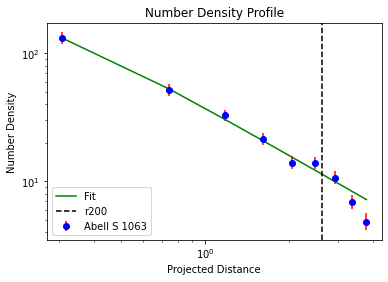

In [38]:
#r200
r_200= 2.63
# Beta profile / Generalized NFW profile function
def Beta_nu(r, rhos, rs, beta):
    return rhos / (1.0 + (r / rs)**2)**beta

# Compute number density profile and plot error bars
def num_den(r_proj, nbins):
    n_data, R_bins = np.histogram(r_proj, nbins, range=(r_proj.min(), r_proj.max()))

    # Ignore bins with zero count
    select = n_data > 0
    n_data = n_data[select]
    R_bins_low = R_bins[:-1][select]
    R_bins_high = R_bins[1:][select]

    # Compute Poisson error in n_data
    n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
    R_bins_ce = 0.5 * (R_bins_low + R_bins_high)

    # Compute projected number density profile
    delta_R2 = (R_bins_high**2 - R_bins_low**2)
    Sig_data = n_data / (np.pi * delta_R2)
    Sig_data_low = n_data_low / (np.pi * delta_R2)
    Sig_data_high = n_data_high / (np.pi * delta_R2)

    # Compute errors
    sig_low = Sig_data - Sig_data_low
    sig_high = Sig_data_high - Sig_data

    # Fit the curve
    parameters, covariance = curve_fit(Beta_nu, R_bins_ce, Sig_data,maxfev=2000)
    fit_rhos, fit_rs, fit_beta = parameters

    # Generate fitted curve
    fit_y = Beta_nu(R_bins_ce, fit_rhos, fit_rs, fit_beta)

    # Plot number density profile with error bars and fitted curve
    plt.errorbar(R_bins_ce, Sig_data, yerr=[sig_low, sig_high], fmt='o', color='blue', ecolor='red', label='Abell S 1063')
    plt.plot(R_bins_ce, fit_y, color='green', label='Fit')
    #plt.errorbar(R_bins_ce, Sig_data, yerr=[sig_low, sig_high], fmt='o', color='blue', ecolor='red')
    plt.axvline(x = 2.63, linestyle='dashed',color = 'black', label = 'r200')

    plt.xlabel('Projected Distance')
    plt.ylabel('Number Density')
    plt.title('Number Density Profile')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

    plt.show()

# Example usage
r_proj = np.random.uniform(low=0, high=10, size=1000)  # Example random projected distance data
nbins = 9  # Number of bins
num_den(trimmed_radius, nbins)


# velocity dispersion profile

In [39]:
def compute_profile(proj_radius, los_v, nbins, method='std', nbootstrap=100):
     # Sort the data by projected radius
    idx = np.argsort(proj_radius)
    proj_radius = proj_radius[idx]
    los_v = los_v[idx]
    
    # Compute the bin edges and centers
    bin_edges = np.linspace(np.min(proj_radius), np.max(proj_radius), nbins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Compute the velocity dispersion in each bin
    v_disp = np.zeros(nbins)
    v_disp_bootstrap = np.zeros((nbins, nbootstrap))
    for i in range(nbins):
        mask = np.logical_and(proj_radius >= bin_edges[i], proj_radius < bin_edges[i+1])
        if method == 'std':
            v_disp[i] = np.std(los_v[mask])
        elif method == 'biweight':
            v_disp[i] = biweight_midvariance(los_v[mask])**0.5
        
        # Perform bootstrap resampling
        for j in range(nbootstrap):
            resample_indices = np.random.choice(np.sum(mask), size=np.sum(mask), replace=True)
            if method == 'std':
                v_disp_bootstrap[i, j] = np.std(los_v[mask][resample_indices])
            elif method == 'biweight':
                v_disp_bootstrap[i, j] = biweight_midvariance(los_v[mask][resample_indices])**0.5
    
    # Fit a power-law model to the profile
    def powerlaw(x, a, b):
        return a * x**b
    
    popt, pcov = curve_fit(powerlaw, bin_centers, v_disp)
    alpha, alpha_err = popt[1], np.sqrt(np.diag(pcov))[1]
    
    return bin_centers, v_disp, alpha, alpha_err, v_disp_bootstrap


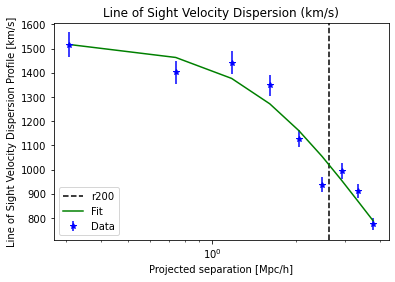

In [40]:
# Define the beta model function
def beta_model(r, sigma0, rc, beta):
    return sigma0 * (1.0 + (r/rc)**2)**(-3*beta/2)

def biweight_est_error(v):
    sigma_err = 0.92 * v_disp / (np.sqrt(v.size - 1))
    return sigma_err

# Compute the velocity dispersion profile
bin_centers, v_disp, alpha, alpha_err, v_disp_bootstrap = compute_profile(trimmed_radius, trimmed_velocity, nbins)

# Compute the error using the biweight estimator
v_disp_err = biweight_est_error(trimmed_velocity)
v_disp_err_std = np.std(v_disp_bootstrap, axis=1)

# Fit the beta model to the velocity dispersion profile
p0 = [10, 1, 0.5]  # Initial guess for parameters
popt, pcov = curve_fit(beta_model, bin_centers, v_disp, p0=p0)
sigma0_fit, rc_fit, beta_fit = popt

# Generate the fitted curve using the fitted parameters
sigma_fit = beta_model(bin_centers, sigma0_fit, rc_fit, beta_fit)

# Plot the velocity dispersion profile with error bars and fitted curve
#plt.figure(figsize=(14,8))
plt.errorbar(bin_centers, v_disp, yerr=v_disp_err, fmt='*', color='blue', ecolor='b', label='Data')
#plt.errorbar(bin_centers, v_disp, yerr=v_disp_err_std, fmt='o', color='blue', ecolor='red', label='Bootstrap (Std)')
plt.axvline(x = 2.63, linestyle='dashed',color = 'black', label = 'r200')

plt.plot(bin_centers, sigma_fit, color='green', label='Fit')
plt.title('Line of Sight Velocity Dispersion (km/s)')
plt.xlabel('Projected separation [Mpc/h]')
plt.ylabel('Line of Sight Velocity Dispersion Profile [km/s]')
plt.legend()
plt.xscale('log')
plt.show()


In [41]:
data = pd.read_csv("s1063.csv")
data

,0.14751329666105498,1411.1671015228428
0,0.407746,1401.014827
1,0.698483,1436.547787
2,0.914195,1395.938690
3,1.161275,1335.025046
4,1.475133,1192.893208
5,1.873817,1370.558005
6,2.310130,1096.446604
7,2.603661,1065.989782
8,3.023566,1076.142056
9,3.511192,1045.685234


In [42]:
with open('s1063.csv', 'r') as file:
        csvreader = csv.reader(file,delimiter=",")
        
        for row in csvreader:
                          
            col3_data = []
            col4_data = []
            
            for row in csvreader:
                                  
                col3_data.append(float(row[0]))
                col4_data.append(float(row[1]))


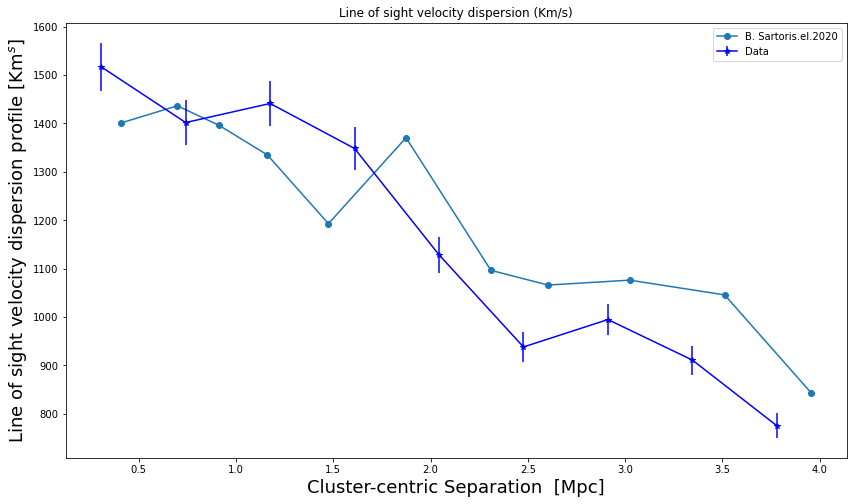

In [43]:
plt.figure(figsize=(14,8))
plt.plot(col3_data,col4_data,'o',linestyle='-',label= 'B. Sartoris.el.2020')  #https://arxiv.org/abs/2003.08475
plt.errorbar(bin_centers, v_disp, yerr=v_disp_err, fmt='*',linestyle='-', color='blue', ecolor='b', label='Data')
plt.title('Line of sight velocity dispersion (Km/s)')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel('Line of sight velocity dispersion profile [Km$^{s}$]',fontsize=18) 
plt.legend()
#plt.xscale('log')
#plt.yscale('log')

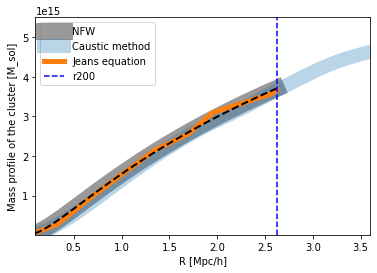

In [44]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the NFW profile function
def nfw_profile(r, Mvir, c):
    x = r / c
    return Mvir * (np.log(1 + x) - x / (1 + x)) / np.log(1 + c)


# Perform curve fitting
p0 = [1e15, 3]  # Initial guess for the parameters [Mvir, c]
params, pcov = curve_fit(nfw_profile, dis, mass_V, p0=p0)

# Extract the fitted parameters
Mvir_fit, c_fit = params

# Generate fitted mass profile
r_fit = np.linspace(min(dis), max(dis), 100)
mass_V_fit = nfw_profile(r_fit, Mvir_fit, c_fit)

# Plot the original data and fitted curve
#plt.figure(figsize=(14,8))
#plt.scatter(dis, mass_V, label='Observed data')
plt.plot(r_fit, mass_V_fit,linewidth = '17' , alpha=0.8, color='gray',label='NFW')
plt.plot(rr,m.massprofile,linestyle='-',linewidth = '14',alpha=0.3,label='Caustic method')
plt.plot(dis,mass_V,linewidth = '5',label='Jeans equation ')
plt.plot(r_fit, mass_V_fit,linestyle='dashed', linewidth=2, color='black')

plt.axvline(x = 2.63, linestyle='dashed',color = 'b', label = 'r200')
plt.xlabel('R [Mpc/h]')
plt.ylabel('Mass profile of the cluster [M_sol]')
plt.xlim(0.1,3.6)
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e13,5.5e15)

#plt.loglog()

plt.legend()
plt.show()


In [45]:
# Print the fitted parameters
print("Fitted parameters:")
print("Mvir =", Mvir_fit)
print("c =", c_fit)


Fitted parameters:
Mvir = 1866568267342249.5
c = 0.572365764987103
